# Welcome !
#### Wind Estimation from flight,  webpage : https://mrtbrnz.github.io/wind_estimation/

#### If you are in Google Colab environment :
- Let's start by cloning the reprository into Google's server 
- Nothing will be installed into your personal computers !!!
- Everything is installed and run on hosted computer, so experiment and enjoy !
- Contact me : murat.bronz(at)enac.fr


<a href="https://colab.research.google.com/github/mrtbrnz/wind_estimation/blob/master/notebooks/simultaneous_wind_estimation_v02.ipynb">
<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
# !!! Run this cell ONLY if you are in Colab !!!
!git clone --recursive https://github.com/mrtbrnz/wind_estimation.git
# git submodule update --init --recursive
%cd wind_estimation/pprz_data
%pip install .
%cd ../notebooks/

In [1]:
# ! sudo apt-get install texlive-latex-recommended 
# ! sudo apt install texlive-latex-extra
# ! sudo apt install dvipng
# ! sudo apt install cm-super

Password:
Password:

### Otherwise, you can continue 
(Assuming that you have cloned the repository and installed the pprz_data utility into your local computer like above)

In [1]:
# Now to import some libraries
import math
import numpy as np
from numpy import sin, cos, pi, sqrt, dot
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import signal
import scipy.optimize
from scipy.signal import savgol_filter
from pprz_data.pprz_data import DATA

from datetime import datetime
import time

In [2]:
def process_pprz_sd(filename, ac_id='7', sample_period=0.01):
    ac_id = ac_id
    pprz = DATA(filename, ac_id, data_type='flight', sample_period=sample_period)
    return pprz.df_All

def process_lidar_file(filename):
    df = pd.read_csv(filename , delimiter='\t', skiprows=41, encoding='iso-8859-1')
    return df

def convert_datetime_to_seconds(t):
    '''Converts date time to seconds starting from 1970 01 01 '''
    # time = "16/08/2013 09:51:43"
    d = datetime.strptime(str(t), "%Y/%m/%d %H:%M:%S.%f")
    return time.mktime(d.timetuple())

def throttle_of_airspeed(v):
    fun = lambda x : x*2.4 + 0
    return fun(v)

In [3]:
def find_index_of_conditioned_time(df, t):
    cond = (df.Position == '0')
    t_i = convert_datetime_to_seconds(df[cond]['Timestamp'].values[0])
    i = 0
    while t_i < t :
        i +=1
        t_i = convert_datetime_to_seconds(df[cond]['Timestamp'].values[i])
    return i

# E.g.
# find_index_of_conditioned_time(lidar_dfs[0], 1622190611.0)

In [4]:
def get_wind_speed_ave(df, altitude, index):
    ''' Requires exact altitude from the list'''
    cond = [(df.Position == '0'),(df.Position == '90'),(df.Position == '180'),(df.Position == '270')]
    wind = np.mean([df[cond[j]][str(altitude)+'m Wind Speed (m/s)'].values[index] for j in range(4)])
    return wind

def get_wind_speed_at_altitude(df, altitude, index):
    ''' Accepts any altitude within the min-max measurements of the Lidar'''
    # find closest alttitude pair
    altitudes = [40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170]
    def find_closest_altitudes(a, altitudes):
        if a < np.min(altitudes) or a >= np.max(altitudes):
            print('Error : Altitude is not within the envelope !!!')
            stop # gives error !
        ind_min = np.argmin(np.abs(np.asarray(altitudes)-a))
        if ind_min == len(altitudes)-1:
            ind_min = len(altitudes)-2
        alt = [altitudes[ind_min],altitudes[ind_min+1]]
        return alt

    alt = find_closest_altitudes(altitude,altitudes)
    wind_low = get_wind_speed_ave(df, alt[0], index)
    wind_high = get_wind_speed_ave(df, alt[1], index)
    #Linear interpolation
    wind = (wind_high - wind_low )/(alt[1]-alt[0])
    wind = wind_low + wind * (altitude - alt[0])
    return wind

#E.g.
# t = 1622190611.0
# altitude = 40
# index = find_index_of_conditioned_time(lidar_dfs[0], t)
# # Linear interpolated values for the existing envelope
# print(f'Wind speed at {altitude} m :',get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)  )
# # Below will only work for the values in the altitudes list... 
# print(f'Ave Wind speed at {altitude} m :',get_wind_speed_ave(lidar_dfs[0], altitude, index) )

In [5]:
# import scipy as sp
# from scipy import signal
from scipy.spatial.transform import Rotation as R

def filter_signal(df, freq=0.2):
    m_coeff = 0.0039063
    v_coeff = 0.0000019
    deg_coeff = 0.0139882

    sf = df.index.shape[0]/(df.index.values[-1]-df.index.values[0])
    print('Sampling Frequency :',sf)
    b, a = signal.butter(4, freq/(sf/2), 'low', analog=False)
    padlen = 0
    alt = df.up.values*m_coeff
    phi = signal.filtfilt(b, a, df.phi, padlen=padlen)*deg_coeff
    theta = signal.filtfilt(b, a, df.theta, padlen=padlen)*deg_coeff # method="gust")
    psi = df.psi.values*deg_coeff
    # psi = np.unwrap(df.psi*deg_coeff)
    # psi = signal.filtfilt(b, a, psi, padlen=padlen)*deg_coeff # method="gust")
    return phi, theta, psi, alt

def smooth_signal(sig, sf=50., freq=0.2):
    b, a = signal.butter(4, freq/(sf/2), 'low', analog=False)
    padlen = 0
    return signal.filtfilt(b, a, sig, padlen=padlen)

In [6]:
# Selected Flight (presented in the paper)
flights={}
flights[1]={'file_sd':'../data/28_05_2021_Muret_wind_propulsion_estimation/Flight_1/21_05_28__10_32_05_SD.data', 'log_time':'2021/05/28 10:32:05', 'file_quad':'../data/28_05_2021_Muret_wind_propulsion_estimation/Wind_Questimator/21_05_28__11_00_02.data','file_lidar':'../data/16_04_2021_Muret/Lidar/WLS71086_2021_04_16__10_57_20.rtd', 'file_probe':'../data/28_05_2021_Muret_wind_propulsion_estimation/'}

In [7]:
dfs={}
for i,values in zip(flights.keys(),flights.values()):
    filename=values['file_sd']
    dfs[i]=process_pprz_sd(filename, sample_period=0.1)
    d = datetime.strptime(values['log_time'], "%Y/%m/%d %H:%M:%S")
    starting_time_in_sec = time.mktime(d.timetuple()) 
    dfs[i]['tseconds'] = dfs[i].index + starting_time_in_sec


 IMU Scaled Acceleration msg doesnt exist 
 IMU Raw Acceleration msg doesnt exist 
 Generating 3D velocity...
 IMU Scaled Gyro msg doesnt exist 
 IMU Raw Gyro msg doesnt exist 
 Fault Telemetry msg doesnt exist 
 Actuators msg doesnt exist 
 4-valued Actuators msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.411 Maximum time : 1507.071


In [8]:
dfs[1].columns

Index(['phi', 'psi', 'theta', 'mode', 'Ax', 'Ay', 'Az', 'east', 'north',
       'course', 'alt', 'vel', 'climb', 'vel_3d', 'Gx', 'Gy', 'Gz', 'C0', 'C1',
       'C2', 'Throttle', 'Volt', 'Amp', 'Watt', 'mAh', 'Wh', 'Ps', 'Pdyn_AD',
       'temp', 'qnh', 'amsl_baro', 'airspeed', 'TAS', 'D_roll', 'D_pitch',
       'D_course', 'D_x', 'D_y', 'D_altitude', 'D_climb', 'D_airspeed',
       'sp_Va', 'sp_aoa', 'sp_beta', 'sp_dyn_p', 'sp_sta_p', 'sp_wx', 'sp_wz',
       'sp_d_wx', 'sp_d_wz', 'sp_w_power', 'tseconds'],
      dtype='object')

## The below cell takes 30minutes to run ! Use the next cell to load directly the pre-calculated result ! 

In [139]:
alt = ave[1] - 186. # dfs[1].alt.values[0]
fw_lidar_wind = np.zeros(len(alt))
fw_time = dfs[1].tseconds[500:1400].values

i = 0
for _fw_time, _alt in zip(fw_time, alt):
    if _alt > np.min(altitudes) and _alt < np.max(altitudes):
        indx = find_index_of_conditioned_time(lidar_dfs[0], _fw_time)
        fw_lidar_wind[i] = get_wind_speed_at_altitude(lidar_dfs[0], _alt, indx)
        print(f'Wind speed at {_alt} m : {fw_lidar_wind[i]} at {_fw_time}'  )
    i+=1


# # Linear interpolated values for the existing envelope
# get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)
# print(f'Wind speed at {altitude} m :',get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)  )

Wind speed at 164.006279999993 m : 4.686459180000045 at 1622191225.0
Wind speed at 163.9490349999926 m : 4.686831272500048 at 1622191225.1
Wind speed at 163.89028666665916 m : 4.687213136666716 at 1622191225.2
Wind speed at 163.836398749993 m : 4.687563408125046 at 1622191225.3
Wind speed at 163.7873659999933 m : 4.687882121000044 at 1622191225.4
Wind speed at 163.74602166666074 m : 4.688150859166705 at 1622191225.5
Wind speed at 163.71220428570894 m : 4.688370672142892 at 1622191225.6
Wind speed at 163.68607812499545 m : 4.6885404921875296 at 1622191225.7
Wind speed at 163.66692444444044 m : 4.688664991111137 at 1622191225.8
Wind speed at 163.6528579999965 m : 4.688756423000023 at 1622191225.9
Wind speed at 163.64262181817872 m : 4.688822958181839 at 1622191226.0
Wind speed at 163.63633999999735 m : 4.688863790000018 at 1622191226.1
Wind speed at 163.6337938461516 m : 4.688880340000015 at 1622191226.2
Wind speed at 163.6350467857124 m : 4.68887219589287 at 1622191226.3
Wind speed at 1

In [13]:
# np.savetxt("fw_lidar_wind_1_500-1400.csv", fw_lidar_wind, delimiter=",")
fw_lidar_wind = np.genfromtxt('fw_lidar_wind_1_500-1400.csv', delimiter=',')

In [14]:
def wind_estimation(df, filename=None):
    beta = df.sp_beta.values #- 0.02
    beta = savgol_filter(beta, 251, 2, axis=0, mode='interp')

    alt = df.alt.values
    # alt = savgol_filter(alt, 1501, 2, axis=0, mode='interp')

    Vg     = df.vel.values
    Vg = savgol_filter(Vg, 151, 2, axis=0, mode='interp')

    course = np.radians(df.course.values*0.1)
    # course_uwrapped = #np.unwrap(course)
    time   = df.index.values
    Vgn = Vg*np.cos(course)
    Vge = Vg*np.sin(course)

    psi = df.psi.values
    # psi = savgol_filter(psi, 1501, 2, axis=0, mode='interp')
    Va  = df.airspeed.values
    Va = savgol_filter(Va, 151, 2, axis=0, mode='interp')

    Van = Va*np.cos(course)
    Vae = Va*np.sin(course)
    
    Van_c = Va*np.cos(course)

    Vwn = Vgn - Van
    Vwe = Vge - Vae
    Vwn = savgol_filter(Vwn, 151, 2, axis=0, mode='interp')
    Vwe = savgol_filter(Vwe, 151, 2, axis=0, mode='interp')
    
    
    #############
    X_rec = np.zeros([len(time),3])

    # States X = [V_tas, W_north, W_east]^T
    X1 = np.array([16.5, 2, -3])

    # F prediction matrix
    F1 = np.eye(3)

    # P covariante matrix
    P1 = np.array([[0.1,   0,   0], \
                [  0,  0.1,   0], \
                [  0,    0, 0.1] ])

    # Q process noise matrix
    qval = 0.00001#0.0001
    Q1 = np.eye(3) * qval

    # C (KF) sensor model matrix, (EKF) Jacobian of the sensor function
    C1 = np.array([[0.0, 0.0, 0.0]]) 

    # R sensor covariance, or measurement noise weight
    R1 = np.array([1.0]) * 1.5

    # I identity matrix
    I = np.eye(3)

    for t in range(len(time)):
        # Propagation
        X1 = F1.dot(X1)
        P1 = F1.dot(P1).dot(F1.T) + Q1

        # Correction (measurements)
        # Extract V_north and V_east inertial velocities from the GPS ground track
        # and Ground Tracking Angle GTA
        V_g = Vg[t] #gps_speed_func(t)
        GTA = course[t] #gps_course_func(t)
        V_n = V_g * cos(GTA)
        V_e = V_g * sin(GTA)

        # Calculate the wind velocity errors
        N_err = V_n - X1[1]
        E_err = V_e - X1[2]

        # Calculate the airspeed magnitude
        V_a_magnitude = sqrt(N_err*N_err+E_err*E_err)
        err = V_a_magnitude - X1[0]

        # C (KF) sensor model matrix, (EKF) Jacobian of the sensor function
        C1[0,0] = -1.
        C1[0,1] = -N_err/V_a_magnitude
        C1[0,2] = -E_err/V_a_magnitude

        # Kalman gain
        S1 = C1.dot(P1).dot(C1.T) + R1
        K1 = P1.dot(C1.T).dot(np.linalg.inv(S1))


        # Update the states and covariance matrix
        X1 = X1 + (K1.dot(0-err)).reshape((3,))
        P1 = P1 - K1.dot(C1).dot(P1)
        X_rec[t] = X1.copy()
    #############
    
    
    # mpl.style.use('default') #seaborn, default, seaborn-paper
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams["font.size"] = 11

    sf = 10 ; freq = 0.05
    fig = plt.figure(figsize=(6,8))
    # plt.plot(np.sqrt(X_rec[:,1]**2+X_rec[:,2]**2), alt-190, label='EKF V wind', alpha=0.4)
    x_ekf_wind = np.sqrt(X_rec[:,1]**2+X_rec[:,2]**2)
    plt.plot(smooth_signal(x_ekf_wind, sf=sf, freq=freq), smooth_signal(alt, sf=sf, freq=freq)-186, lw=2,label='EKF Wind Speed')
    
    plt.grid();plt.legend();plt.xlim([3.,6.])
    return x_ekf_wind, alt


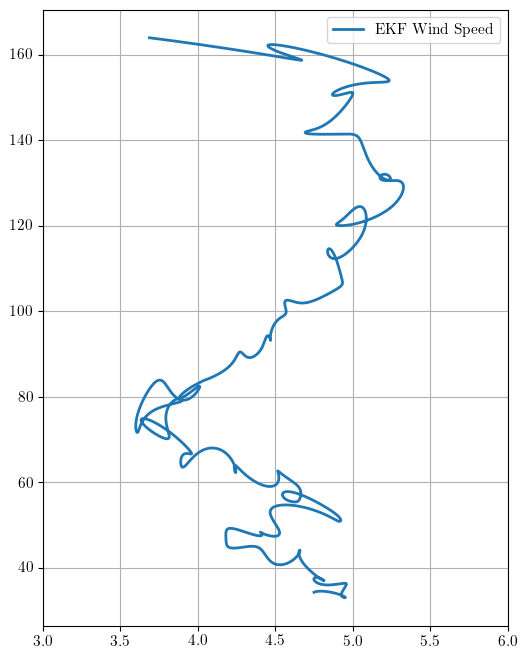

In [15]:
ekf_wind, ekf_alt = wind_estimation(dfs[1][500:1400])

In [16]:
def wind_estimation_EKF_Va(df, filename=None):
    beta = df.sp_beta.values #- 0.02
    beta = savgol_filter(beta, 251, 2, axis=0, mode='interp')

    alt = df.alt.values
    # alt = savgol_filter(alt, 1501, 2, axis=0, mode='interp')

    Vg     = df.vel.values
    Vg = savgol_filter(Vg, 151, 2, axis=0, mode='interp')

    course = np.radians(df.course.values*0.1)

    time   = df.index.values

    Vgn = Vg*np.cos(course)
    Vge = Vg*np.sin(course)

    psi = df.psi.values

    Va  = df.airspeed.values
    Va = savgol_filter(Va, 151, 2, axis=0, mode='interp')
    
    #############
    X_rec = np.zeros([len(time),3])

    # States X = [V_tas, W_north, W_east]^T
    X = np.array([16.5, 2, -3])

    # F prediction matrix
    F = np.eye(3)

    # P covariante matrix
    P = np.array([[0.1,   0,   0], \
                [  0,  0.1,   0], \
                [  0,    0, 0.1] ])

    # Q process noise matrix
    qval = 0.00001 #0.0001
    Q = np.eye(3) * qval

    # H (KF) sensor model matrix, (EKF) Jacobian of the sensor function
    H = np.zeros((2,3)) 

    # Z measurements
    Z = np.zeros((2))

    # R sensor covariance, or measurement noise weight
    R = np.array([10.15, 0.0001])

    # I identity matrix
    I = np.eye(3)

    for t in range(len(time)):
        # Propagation
        X = F.dot(X)
        P = F.dot(P).dot(F.T) + Q

        # Correction (measurements)
        # Extract V_north and V_east inertial velocities from the GPS ground track
        # and Ground Tracking Angle GTA
        V_g = Vg[t] #gps_speed_func(t)
        GTA = course[t] #gps_course_func(t)
        V_n = V_g * cos(GTA)
        V_e = V_g * sin(GTA)

        # Calculate the wind velocity errors
        N_err = V_n - X[1]
        E_err = V_e - X[2]

        # Calculate the airspeed magnitude
        V_a_magnitude = sqrt(N_err*N_err+E_err*E_err)
        err = V_a_magnitude - X[0]

        # C (KF) sensor model matrix, (EKF) Jacobian of the sensor function
        H[0,0] = -1.
        H[0,1] = -N_err/V_a_magnitude
        H[0,2] = -E_err/V_a_magnitude
        H[1,0] =  1.

        # Kalman gain
        S = H.dot(P).dot(H.T) + R
        K = P.dot(H.T).dot(np.linalg.inv(S))


        # Update the states and covariance matrix
        Z[1] = Va[t] # measured airspeed
        diff = np.array([ 0-err , Z[1]-X[0] ])
        X = X + (K @ diff)
        P = P - K.dot(H).dot(P)
        X_rec[t] = X.copy()
    #############
    
    
    #mpl.style.use('default') #seaborn, default, seaborn-paper
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams["font.size"] = 11

    sf = 10 ; freq = 0.05
    fig = plt.figure(figsize=(6,8))
    # plt.plot(np.sqrt(X_rec[:,1]**2+X_rec[:,2]**2), alt-190, label='EKF V wind', alpha=0.4)
    x_ekf_wind = np.sqrt(X_rec[:,1]**2+X_rec[:,2]**2)
    plt.plot(smooth_signal(x_ekf_wind, sf=sf, freq=freq), smooth_signal(alt, sf=sf, freq=freq)-190, lw=2,label='EKF (GPS + $V_A$) Wind Speed')
    # plt.plot(smooth_signal(Va, sf=sf, freq=freq), smooth_signal(alt, sf=sf, freq=freq)-190, lw=2,label='Airspeed')
    plt.grid();plt.legend();plt.xlim([3.,6.])
    return x_ekf_wind, alt , X_rec

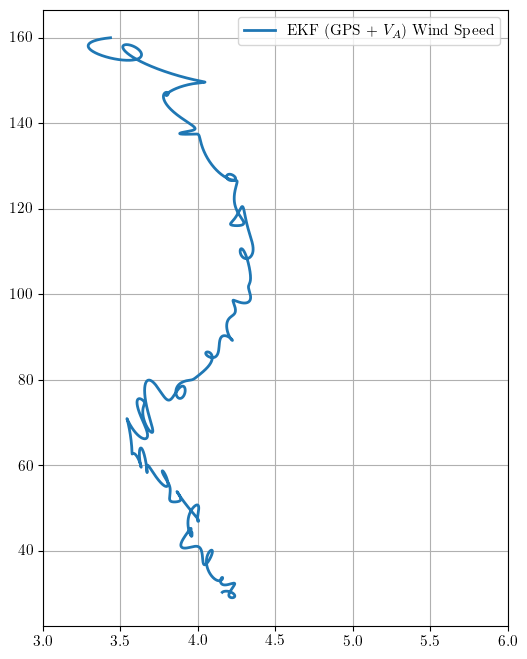

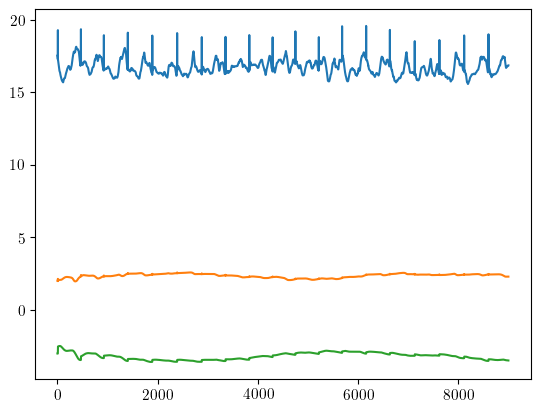

In [18]:
ekf2_wind, ekf2_alt, ekf2_X =  wind_estimation_EKF_Va(dfs[1][500:1400])
fig = plt.figure()
plt.plot(ekf2_X[:,:])
plt.show()

In [81]:
# Lets optimize
# from scipy.optimize import minimize 
# import scipy.optimize

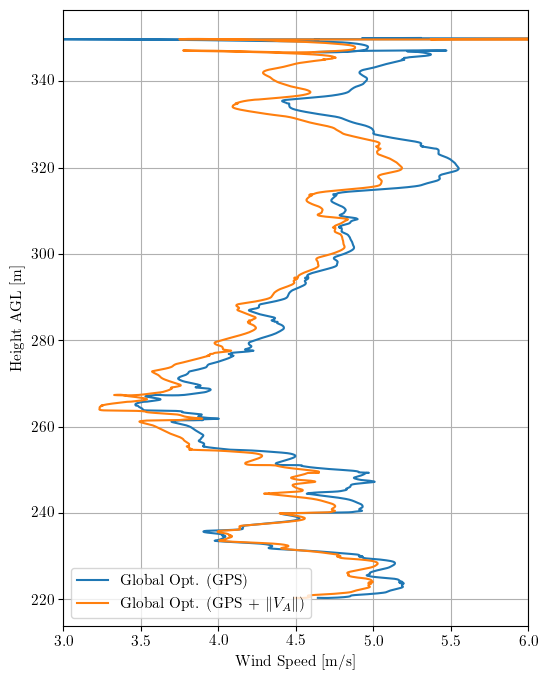

In [19]:
class CircularBuffer(object):
    def __init__(self, size):
        """initialization"""
        self.index= 0
        self.size= size
        self._data = []

    def record(self, value):
        """append an element"""
        if len(self._data) == self.size:
            self._data[self.index]= value
        else:
            self._data.append(value)
        self.index= (self.index + 1) % self.size

    def __getitem__(self, key):
        """get element by index like a regular array"""
        return(self._data[key])

    def __repr__(self):
        """return string representation"""
        return self._data.__repr__() + ' (' + str(len(self._data))+' items)'

    def get_all(self):
        """return a list of all the elements"""
        return(self._data)


def ground_vec_optimize(df, filename=None):

    alt = df.alt.values
    # alt = savgol_filter(alt, 1501, 2, axis=0, mode='interp')

    Vg = df.vel.values
    Vg = savgol_filter(Vg, 151, 2, axis=0, mode='interp')

    Va  = df.airspeed.values
    Va = savgol_filter(Va, 151, 2, axis=0, mode='interp')

    course = np.radians(df.course.values*0.1)
    # course_uwrapped = #np.unwrap(course)
    time   = df.index.values
    Vgn = Vg*np.cos(course)
    Vge = Vg*np.sin(course)

    def circular_fit(C):
        ''' Function fitting arbitrary lenght array of 2D vectors to the nearest circle equation
            Inputs   : C-vector including center point and radius of the circle
            Outputs  : Fitting error as RMSE
            Requires : X-vector as 2D ground speed [Vgn, Vge] , sample size can be arbitrary,
        need to be defined according to the coverage of the circle'''
        x0,y0,r = C
        e = (X[0]-x0)**2 + (X[1]-y0)**2 - r**2
        se = np.power(e, 2)
        rse = np.sqrt(np.sum(se))
        rmse = rse / e.shape[0]
        return rmse

    def circular_fit_2(C):
        ''' Function fitting arbitrary lenght array of 2D vectors to the nearest circle equation
            Inputs   : C-vector is the center point of the circle, 
            Outputs  : Fitting error as RMSE
            Requires : X-vector as 2D ground speed and airspeed [Vgn, Vge, Va] , sample size can be arbitrary,
        need to be defined according to the coverage of the circle'''
        x0,y0 = C
        e = (X_2[0]-x0)**2 + (X_2[1]-y0)**2 - np.array(X_2[2])**2
        se = np.power(e, 2)
        rse = np.sqrt(np.sum(se))
        rmse = rse / e.shape[0]
        return rmse

    C0 = [-5.,-5.,15.]
    C0_2 = [-5.,-5.]
    sample_size = 500

    CB_Vgn = CircularBuffer(sample_size)
    CB_Vge = CircularBuffer(sample_size)
    CB_Va  = CircularBuffer(sample_size)
    CB_alt = CircularBuffer(sample_size)
    CB_time = CircularBuffer(sample_size)

    wind    = np.zeros(len(alt))
    wind_2  = np.zeros(len(alt))
    alt_ave = np.zeros(len(alt))
    time_ave= np.zeros(len(alt))

    for t in range(len(time)):
        CB_Vgn.record(Vgn[t]) ; CB_Vge.record(Vge[t]) ; CB_Va.record(Va[t]) ; CB_alt.record(alt[t]) ; CB_time.record(time[t]) ; 
        # X = [CB_Vgn.get_all(), CB_Vge.get_all()]
        X = [CB_Vgn.get_all(), CB_Vge.get_all()]
        result = scipy.optimize.minimize(circular_fit, C0, method="nelder-mead")
        C0 = result['x']
        wind[t] = C0[0]**2 + C0[1]**2

        X_2 = [CB_Vgn.get_all(), CB_Vge.get_all(), CB_Va.get_all()]
        result = scipy.optimize.minimize(circular_fit_2, C0_2, method="nelder-mead")
        C0_2 = result['x']
        wind_2[t] = C0_2[0]**2 + C0_2[1]**2

        alt_ave[t] = np.sum(CB_alt.get_all())/ len(CB_alt.get_all() )
        time_ave[t] = np.sum(CB_time.get_all())/ len(CB_time.get_all() )
    

    fig = plt.figure(figsize=(6,8))
    plt.plot(np.sqrt(wind), alt_ave, label='Global Opt. (GPS)')
    plt.plot(np.sqrt(wind_2), alt_ave, label='Global Opt. (GPS + $\|V_A\|$)')
    plt.xlim([3.,6.])
    plt.grid();plt.xlabel('Wind Speed [m/s]');plt.ylabel('Height AGL [m]');plt.legend()
    

    return time_ave, alt_ave , wind, wind_2

    
ave = ground_vec_optimize(dfs[1][500:1400])

In [23]:
alt = ave[1] - 186. # dfs[1].alt.values[0]
fw_time = dfs[1].tseconds[500:1400].values

# sf = 10 ; freq = 0.02
# plt.plot(smooth_signal(fw_lidar_wind, sf=sf, freq=freq), smooth_signal(alt, sf=sf, freq=freq), color='purple')
# plt.show()

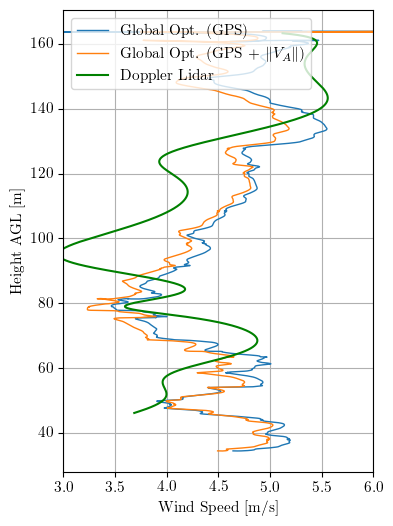

In [24]:
sf = 10 ; freq = 0.008

fig = plt.figure(figsize=(4,6))
plt.plot(np.sqrt(ave[2]), ave[1]-186, lw=1, label='Global Opt. (GPS)')
plt.plot(np.sqrt(ave[3]), ave[1]-186, lw=1, label='Global Opt. (GPS + $\|V_A\|$)')

plt.plot(smooth_signal(fw_lidar_wind[np.where(alt>40)], sf=sf, freq=freq), smooth_signal(alt[np.where(alt>40)], sf=sf, freq=freq), color='green', label='Doppler Lidar')
plt.xlim([3.,6.])
plt.grid();plt.xlabel('Wind Speed [m/s]');plt.ylabel('Height AGL [m]');plt.legend(loc='upper left')
# plt.savefig('plots/fw_nelder_mead_vs_lidar.pdf', dpi=30, bbox_inches='tight')
plt.show()

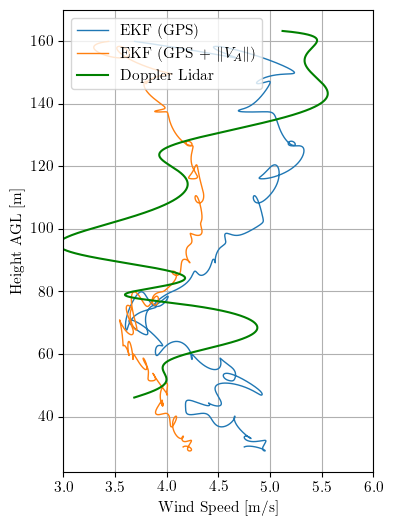

In [25]:

sf = 10 ; freq = 0.05
fig = plt.figure(figsize=(4,6))
plt.plot(smooth_signal(ekf_wind, sf=sf, freq=freq), smooth_signal(ekf_alt, sf=sf, freq=freq)-190, lw=1,label='EKF (GPS)')
plt.plot(smooth_signal(ekf2_wind, sf=sf, freq=freq), smooth_signal(ekf2_alt, sf=sf, freq=freq)-190, lw=1,label='EKF (GPS + $\|V_A\|$)')

sf = 10 ; freq = 0.008
plt.plot(smooth_signal(fw_lidar_wind[np.where(alt>40)], sf=sf, freq=freq), smooth_signal(alt[np.where(alt>40)], sf=sf, freq=freq), color='green', label='Doppler Lidar')
plt.xlim([3.,6.])
# plt.xlim([0.,9.])
plt.grid();plt.xlabel('Wind Speed [m/s]');plt.ylabel('Height AGL [m]');plt.legend()
# plt.savefig('plots/ekfs_vs_lidar.pdf', dpi=30, bbox_inches='tight')
plt.show()

In [26]:
def plot_trajectory(df,limits=(0,2000), save_fig=False):
    m_coeff = 0.0039063
    v_coeff = 0.0000019
    deg_coeff = 0.0139882
    
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams["font.size"] = 11
    
    st,fn = limits
    x = df[st:fn].east.values*m_coeff ; x=x-x[0]
    y = df[st:fn].north.values*m_coeff ; y=y-y[0]
    z = df[st:fn].alt.values #; z=z-z[0]
    Ax = df[st:fn].Ax.values
    Az = df[st:fn].Az.values
    climb = df[st:fn].climb.values
    throttle = df[st:fn].Throttle.values
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(-x,y,z)
    ax.dist = 12
    ax.set_xlabel('North [m]')
    ax.set_ylabel('East [m]')
    ax.set_zlabel('Altitude ASL [m]')
    if save_fig:
        plt.savefig('plots/'+ 'flight1_spiral_descend_3d.pdf', dpi=30, bbox_inches='tight')
    plt.show()

/var/folders/ss/3bb0hr1s09xbpzwgbl2pqt2r0000gn/T/ipykernel_18621/3075687129.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


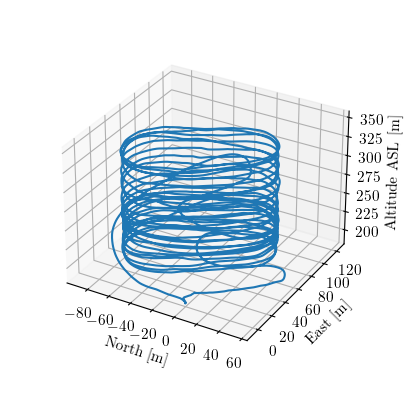

In [27]:
plot_trajectory(dfs[1], save_fig=False)

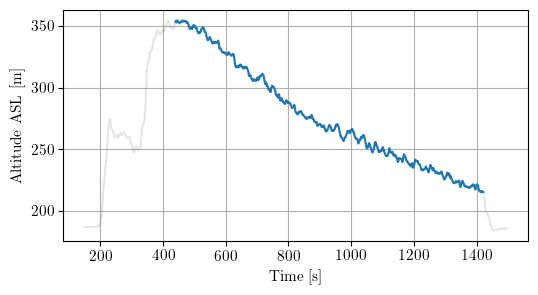

In [28]:
time_list=[(440,1420)]
st=150;fn=1800
dfs[1][st:fn].alt.plot(figsize=(6,3), color='grey' ,alpha=0.2)
# Uncomment the below 3 lines for pretty plots (Does NOT work in Colab !)
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = "Serif"
# plt.rcParams["font.size"] = 11 
for i in range(len(time_list)):
    st=time_list[i][0] ; fn=time_list[i][1]
    alt = dfs[1][st:fn].alt.plot()
plt.xlabel('Time [s]')
plt.ylabel('Altitude ASL [m]')
plt.grid()
# plt.savefig('plots/'+ 'flight1_spiral_descend.pdf', dpi=30, bbox_inches='tight')
plt.show()

# Reading and Analysing WINDCUBE LIDAR Measurements :

In [30]:
lidar_dfs={}
filename='../data/28_05_2021_Muret_wind_propulsion_estimation/lidar/WLS71086_2021_05_28__10_16_35.rtd'
lidar_dfs[0]=process_lidar_file(filename)

In [32]:
lidar_dfs[0].head(10)

,Timestamp,Position,Temperature,Wiper Count,40m CNR (dB),40m Radial Wind Speed (m/s),40m Radial Wind Speed Dispersion (m/s),40m Wind Speed (m/s),40m Wind Direction (°),40m X-wind (m/s),...,Unnamed: 174,170m CNR (dB),170m Radial Wind Speed (m/s),170m Radial Wind Speed Dispersion (m/s),170m Wind Speed (m/s),170m Wind Direction (°),170m X-wind (m/s),170m Y-wind (m/s),170m Z-wind (m/s),Unnamed: 183
0,2021/05/28 10:16:35.77,V,21.2,0,-14.13,-0.28,0.02,NaN,NaN,NaN,...,NaN,-13.48,0.65,0.02,NaN,NaN,NaN,NaN,0.651,NaN
1,2021/05/28 10:16:36.57,0,21.2,0,-15.32,-1.24,0.02,5.70,140.70,-4.409,...,NaN,-14.98,-1.65,0.02,4.96,132.13,-3.330,3.682,0.651,NaN
2,2021/05/28 10:16:37.37,90,21.2,0,-14.66,2.02,0.02,5.70,140.70,-4.409,...,NaN,-14.20,1.89,0.02,4.96,132.13,-3.330,3.682,0.651,NaN
3,2021/05/28 10:16:38.17,180,21.2,0,-14.61,2.90,0.02,5.70,140.70,-4.409,...,NaN,-14.16,1.48,0.02,4.96,132.13,-3.330,3.682,0.651,NaN
4,2021/05/28 10:16:38.97,270,21.2,0,-16.19,-1.36,0.02,5.70,140.70,-4.409,...,NaN,-15.75,-1.57,0.02,4.96,132.13,-3.330,3.682,0.651,NaN
5,2021/05/28 10:16:39.77,V,21.2,0,-13.97,0.59,0.02,NaN,NaN,NaN,...,NaN,-13.56,0.12,0.02,NaN,NaN,NaN,NaN,0.120,NaN
6,2021/05/28 10:16:40.57,0,21.2,0,-14.17,-1.39,0.02,5.83,141.74,-4.575,...,NaN,-14.52,-1.18,0.02,4.64,127.55,-2.831,3.682,0.120,NaN
7,2021/05/28 10:16:41.37,90,21.2,0,-14.85,1.74,0.02,5.64,144.18,-4.575,...,NaN,-14.52,1.26,0.02,4.13,133.25,-2.831,3.010,0.120,NaN
8,2021/05/28 10:16:42.17,180,21.2,0,-15.09,1.99,0.02,4.89,137.51,-3.605,...,NaN,-14.12,1.69,0.02,4.29,135.42,-3.054,3.010,0.120,NaN
9,2021/05/28 10:16:42.97,270,21.2,0,-16.25,-0.86,0.02,4.54,142.51,-3.605,...,NaN,-15.91,-1.59,0.02,4.31,135.16,-3.054,3.037,0.120,NaN


In [33]:
# Here are the columns
for column in lidar_dfs[0].columns:
    print(column)

Timestamp
Position
Temperature
Wiper Count
40m CNR (dB)
40m Radial Wind Speed (m/s)
40m Radial Wind Speed Dispersion (m/s)
40m Wind Speed (m/s)
40m Wind Direction (°)
40m X-wind (m/s)
40m Y-wind (m/s)
40m Z-wind (m/s)
Unnamed: 12
45m CNR (dB)
45m Radial Wind Speed (m/s)
45m Radial Wind Speed Dispersion (m/s)
45m Wind Speed (m/s)
45m Wind Direction (°)
45m X-wind (m/s)
45m Y-wind (m/s)
45m Z-wind (m/s)
Unnamed: 21
50m CNR (dB)
50m Radial Wind Speed (m/s)
50m Radial Wind Speed Dispersion (m/s)
50m Wind Speed (m/s)
50m Wind Direction (°)
50m X-wind (m/s)
50m Y-wind (m/s)
50m Z-wind (m/s)
Unnamed: 30
55m CNR (dB)
55m Radial Wind Speed (m/s)
55m Radial Wind Speed Dispersion (m/s)
55m Wind Speed (m/s)
55m Wind Direction (°)
55m X-wind (m/s)
55m Y-wind (m/s)
55m Z-wind (m/s)
Unnamed: 39
60m CNR (dB)
60m Radial Wind Speed (m/s)
60m Radial Wind Speed Dispersion (m/s)
60m Wind Speed (m/s)
60m Wind Direction (°)
60m X-wind (m/s)
60m Y-wind (m/s)
60m Z-wind (m/s)
Unnamed: 48
65m CNR (dB)
65m Radia

In [34]:
# Too lazy to do it automatically...
altitudes = [40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170]

In [17]:
# You can read any value like this :
# lidar_dfs[4].loc[4,].values[2]
# lidar_dfs[4].iloc[:,2].values
# Or give a condition to select :
# cond = lidar_dfs[4].Position == 'V'
# cond = lidar_dfs[4].Position == '90'
# lidar_dfs[4][cond].iloc[:,2]

In [36]:
# utility function...
convert_datetime_to_seconds(lidar_dfs[0]['Timestamp'].values[1])
# lidar_dfs[0][str(50)+'m Wind Speed (m/s)'].values[1]

1622189796.0

In [39]:
def plot_wind(df):
    fig=plt.figure(figsize=(5,10))
    for i in range(10):
        wind_array = [df[str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes]
        plt.plot(wind_array,altitudes)
    plt.ylabel('Height AGL [m]')
    plt.xlabel('Wind Speed [m/s]')

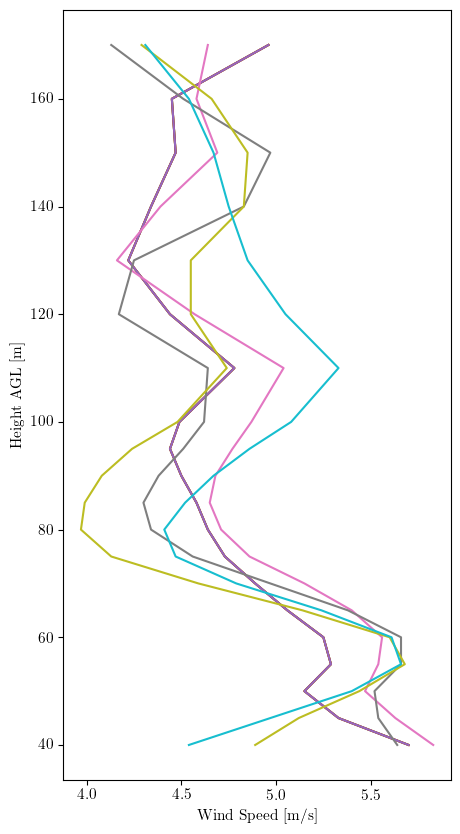

In [40]:
plot_wind(lidar_dfs[0])

2021/05/28 10:16:36.57
2021/05/28 10:22:36.57
2021/05/28 10:28:36.57
2021/05/28 10:34:36.57
2021/05/28 10:40:36.57
2021/05/28 10:46:36.57
2021/05/28 10:52:36.57
2021/05/28 10:58:36.57
2021/05/28 11:04:36.57
2021/05/28 11:10:36.57
2021/05/28 11:16:36.57
2021/05/28 11:22:36.57
2021/05/28 11:28:36.57
2021/05/28 11:34:36.57
2021/05/28 11:40:36.57
2021/05/28 11:46:36.57


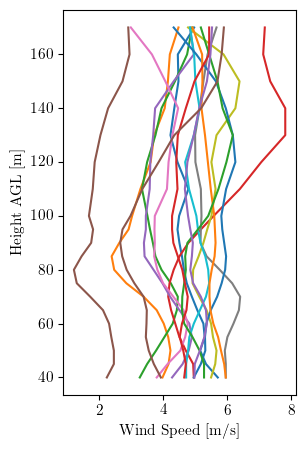

In [41]:
def plot_wind_2(df):
    fig=plt.figure(figsize=(3,5))
    cond = [(df.Position == '0'),(df.Position == '90'),(df.Position == '180'),(df.Position == '270')]
    for i in range(0,1400,90):
        wind_array = [df[cond[0]][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes]
        print(df[cond[0]]['Timestamp'].values[i])
        plt.plot(wind_array,altitudes, )
    plt.ylabel('Height AGL [m]')
    plt.xlabel('Wind Speed [m/s]')
#     plt.savefig('plots/'+ 'lidar_101636_114636_every_6min.pdf', dpi=30, bbox_inches='tight')

plot_wind_2(lidar_dfs[0])

['2021/05/28 10:16:36.57', '2021/05/28 10:16:37.37', '2021/05/28 10:16:38.17', '2021/05/28 10:16:38.97']
['2021/05/28 10:16:40.57', '2021/05/28 10:16:41.37', '2021/05/28 10:16:42.17', '2021/05/28 10:16:42.97']
['2021/05/28 10:16:44.57', '2021/05/28 10:16:45.37', '2021/05/28 10:16:46.17', '2021/05/28 10:16:46.97']
['2021/05/28 10:16:48.57', '2021/05/28 10:16:49.37', '2021/05/28 10:16:50.17', '2021/05/28 10:16:50.97']
['2021/05/28 10:16:52.57', '2021/05/28 10:16:53.37', '2021/05/28 10:16:54.17', '2021/05/28 10:16:54.97']


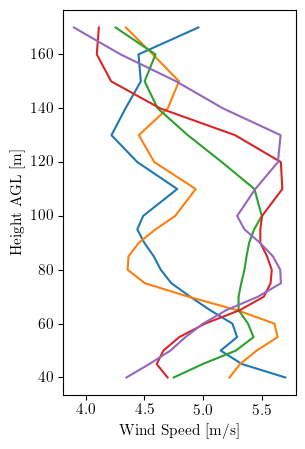

In [42]:
# Lets average all directions and find the middle point...

def plot_wind_dir_ave(df):
    fig=plt.figure(figsize=(3,5))
    cond = [(df.Position == '0'),(df.Position == '90'),(df.Position == '180'),(df.Position == '270')]
    # for i in range(0,1400,90):
    for i in range(0,5,1):
        wind_array = np.mean([[df[cond[j]][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes] for j in range(4)], axis=0)
        print([df[cond[j]]['Timestamp'].values[i] for j in range(4)])
        # print(wind_array)
        plt.plot(wind_array,altitudes, )
    plt.ylabel('Height AGL [m]')
    plt.xlabel('Wind Speed [m/s]')
#     plt.savefig('plots/'+ 'lidar_101636_114636_every_6min.pdf', dpi=30, bbox_inches='tight')

plot_wind_dir_ave(lidar_dfs[0])

2021/05/28 10:17:56.57
2021/05/28 10:18:00.57
2021/05/28 10:18:04.57
2021/05/28 10:18:08.57
2021/05/28 10:18:12.57
2021/05/28 10:18:16.56
2021/05/28 10:18:20.57
2021/05/28 10:18:24.57
2021/05/28 10:18:28.57
2021/05/28 10:18:32.57
2021/05/28 10:18:36.57
2021/05/28 10:18:40.57
2021/05/28 10:18:44.57
2021/05/28 10:18:48.57
2021/05/28 10:18:52.57


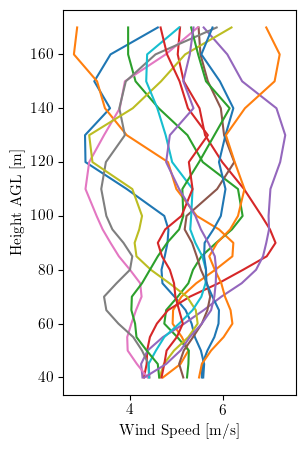

In [43]:
def plot_wind_3(df):
    fig=plt.figure(figsize=(3,5))
    cond = df.Position == '0'
    for i in range(20,35,1):
        wind_array = [df[cond][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes]
        print(df[cond]['Timestamp'].values[i])
        plt.plot(wind_array,altitudes, )
    plt.ylabel('Height AGL [m]')
    plt.xlabel('Wind Speed [m/s]')
#     plt.savefig('plots/'+ 'lidar_101756_ between 101852_every_4s.pdf', dpi=30, bbox_inches='tight')

plot_wind_3(lidar_dfs[0])

In [44]:
i = 1
cond = [(lidar_dfs[0].Position == '0'),(lidar_dfs[0].Position == '90'),(lidar_dfs[0].Position == '180'),(lidar_dfs[0].Position == '270')]
wind_array = np.mean([[lidar_dfs[0][cond[j]][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes] for j in range(4)], axis=0)
print(wind_array)

[5.225  5.315  5.4575 5.635  5.6075 5.29   4.875  4.505  4.3575 4.365
 4.4525 4.595  4.7625 4.9375 4.585  4.4525 4.7    4.795  4.5725 4.3425]


In [45]:
convert_datetime_to_seconds(lidar_dfs[0]['Timestamp'].values[1020])
# lidar_dfs[0][str(50)+'m Wind Speed (m/s)'].values[1]

1622190611.0

In [46]:
t = 1622190611.0
altitude = 40
index = find_index_of_conditioned_time(lidar_dfs[0], t)
# Linear interpolated values for the existing envelope
print(f'Wind speed at {altitude} m :',get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)  )
# Below will only work for the values in the altitudes list... 
print(f'Ave Wind speed at {altitude} m :',get_wind_speed_ave(lidar_dfs[0], altitude, index) )

Wind speed at 40 m : 4.5275
Ave Wind speed at 40 m : 4.5275


In [47]:
ind_min = np.argmin(np.abs(np.asarray(altitudes)-60.))
print([altitudes[ind_min],altitudes[ind_min+1]])

[60, 65]


In [24]:
# wind_array = [[lidar_dfs[0][cond][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes] for i in range(3)]
# np.asarray(wind_array).mean(axis=0)

In [48]:
def plot_wind_mean(df):
    fig=plt.figure(figsize=(3,5))
    cond = df.Position == '0'
    sample =500
    for i in range(sample):
        wind_array = [df[cond][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes]
        plt.plot(wind_array,altitudes, 'b', lw=0.1, alpha=0.4)
#         if i == sample-1:
#             print(df[cond]['Timestamp'][i])
        
        
    wind_array = [[df[cond][str(alt)+'m Wind Speed (m/s)'].values[i] for alt in altitudes] for i in range(sample)]
    wind_array_mean = np.asarray(wind_array).mean(axis=0)
    plt.plot(wind_array_mean,altitudes, 'b', lw=3)
    
    plt.ylabel('Height AGL [m]')
    plt.xlabel('Wind Speed [m/s]')
#     plt.savefig('plots/'+ 'lidar_mean_500.png', dpi=100, bbox_inches='tight')

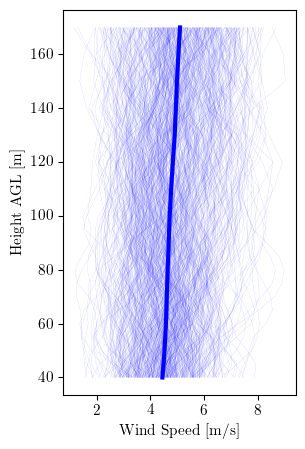

In [49]:
plot_wind_mean(lidar_dfs[0])

In [314]:
lidar_dfs[0][cond]['Timestamp'].values[499]

'2021/05/28 10:49:52.57'

<AxesSubplot:>

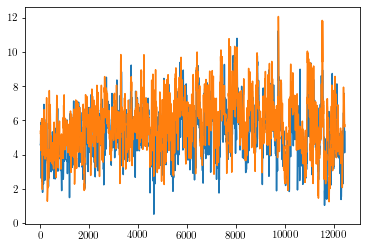

In [57]:
lidar_dfs[4][cond]['40m Wind Speed (m/s)'].plot()
lidar_dfs[4][cond]['150m Wind Speed (m/s)'].plot()

# Quadrotor Based Wind Estimation Part

In [51]:
ac_id = "11"
filenames = ['../data/28_05_2021_Muret_wind_propulsion_estimation/Wind_Questimator/21_05_28__11_00_02.data', '../data/28_05_2021_Muret_wind_propulsion_estimation/Wind_Questimator/21_05_28__11_35_18.data' ]# First and Second run
log_times = ['2021/05/28 11:00:02' , '2021/05/28 11:35:18']
# flight_1 = DATA(filename, ac_id, data_type='flight', sample_period=0.02)
# df1 = flight_1.df_All.copy()

quad_dfs={}
for i,filename in enumerate(filenames): #zip(flights.keys(),flights.values()):
    quad_dfs[i]=DATA(filename, ac_id, data_type='flight', sample_period=0.1).df_All.copy()
    # time format : "21/05/28 11:00:02"
    d = datetime.strptime(log_times[i], "%Y/%m/%d %H:%M:%S")
    starting_time_in_sec = time.mktime(d.timetuple()) 
    quad_dfs[i]['tseconds'] = quad_dfs[i].index + starting_time_in_sec
    

 Attitude msg doesnt exist 
Paparazzi Mode msg doesnt exist 
 IMU Acceleration msg doesnt exist 
 IMU Scaled Acceleration msg doesnt exist 
 IMU Raw Acceleration msg doesnt exist 
 GPS msg doesnt exist 
 IMU Gyro msg doesnt exist 
 IMU Scaled Gyro msg doesnt exist 
 IMU Raw Gyro msg doesnt exist 
 Fault Telemetry msg doesnt exist 
 Actuators msg doesnt exist 
 Commands msg doesnt exist 
 Desired msg doesnt exist 
 4-valued Actuators msg doesnt exist 
 Gust msg does not exist 
 Soaring Telemetry msg does not exist 
Min time : 5.296 Maximum time : 565.592
 Attitude msg doesnt exist 
Paparazzi Mode msg doesnt exist 
 IMU Acceleration msg doesnt exist 
 IMU Scaled Acceleration msg doesnt exist 
 IMU Raw Acceleration msg doesnt exist 
 GPS msg doesnt exist 
 IMU Gyro msg doesnt exist 
 IMU Scaled Gyro msg doesnt exist 
 IMU Raw Gyro msg doesnt exist 
 Fault Telemetry msg doesnt exist 
 Actuators msg doesnt exist 
 Commands msg doesnt exist 
 Desired msg doesnt exist 
 4-valued Actuators msg

In [52]:
print(f' Doppler Lidar was logging between ',lidar_dfs[0]['Timestamp'].values[0],' and  ',lidar_dfs[0]['Timestamp'].values[-1]) 
print(' Glider flight starts at 21_05_28__10_32_05_SD')
print(f' Quadrotor flight were at {log_times[0]} and {log_times[1]}')

 Doppler Lidar was logging between  2021/05/28 10:16:35.77  and   2021/05/28 11:46:42.17
 Glider flight starts at 21_05_28__10_32_05_SD
 Quadrotor flight were at 2021/05/28 11:00:02 and 2021/05/28 11:35:18


In [55]:
quad_dfs[0].up
quad_dfs[0].columns

Index(['Throttle', 'Volt', 'Amp', 'Watt', 'mAh', 'Wh', 'Ps', 'Pdyn_AD', 'temp',
       'qnh', 'amsl_baro', 'airspeed', 'TAS', 'east', 'north', 'up', 'veast',
       'vnorth', 'vup', 'phi', 'theta', 'psi', 'carrot_east', 'carrot_north',
       'carrot_up', 'carrot_psi', 'thrust', 'flight_time', 'tseconds'],
      dtype='object')

Sampling Frequency : 10.00219876868957
Sampling Frequency : 10.001945903872208


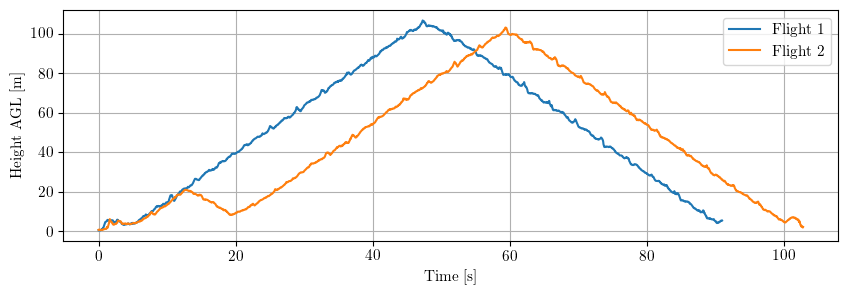

In [58]:
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Serif"
plt.rcParams["font.size"] = 11  
fig=plt.figure(figsize=(10,3))

for flight_nr in range(2):
    phi, theta, psi, alt = filter_signal(quad_dfs[flight_nr][100:800], freq=0.2)


    # alt = smooth_signal(alt, freq=0.02)
    # high=np.where(alt==max(alt))[0][0]
    # plt.plot(total_inclination[:high],alt[:high], label='During Ascend')
    # plt.plot(total_inclination[high:],alt[high:], label='During Descend')
    plt.plot(np.arange(len(alt))/50, alt, label=f'Flight {flight_nr+1}')
    # plt.plot(psi)
plt.grid();plt.xlabel('Time [s]');plt.ylabel('Height AGL [m]');plt.legend()

# plt.savefig('plots/quad_climb_descend.pdf', dpi=30, bbox_inches='tight')
plt.show()

In [59]:
flight_nr = 0
quad_dfs[flight_nr].tseconds

time
15.0     1.622192e+09
15.1     1.622192e+09
15.2     1.622192e+09
15.3     1.622192e+09
15.4     1.622192e+09
             ...     
554.5    1.622193e+09
554.6    1.622193e+09
554.7    1.622193e+09
554.8    1.622193e+09
554.9    1.622193e+09
Name: tseconds, Length: 5400, dtype: float64

In [78]:
flight_nr

1

## Now we will add lidar data into quad flight dataframe

# The below cell takes long 

In [276]:
# t = 1622190611.0
# altitude = 40
# stop
q_lidar_wind = np.zeros(len(alt))
i = 0
for _q_time, _alt in zip(q_time, alt):
    if _alt > np.min(altitudes) and _alt < np.max(altitudes):
        indx = find_index_of_conditioned_time(lidar_dfs[0], _q_time)
        q_lidar_wind[i] = get_wind_speed_at_altitude(lidar_dfs[0], _alt, indx)
        print(f'Wind speed at {_alt} m : {q_lidar_wind[i]} at {_q_time}'  )
    i+=1


# # Linear interpolated values for the existing envelope
# get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)
# print(f'Wind speed at {altitude} m :',get_wind_speed_at_altitude(lidar_dfs[0], altitude, index)  )

Wind speed at 40.009545318752615 m : 5.575310222859459 at 1622194788.7
Wind speed at 40.119048000004824 m : 5.578869060000156 at 1622194788.8
Wind speed at 40.248982348105656 m : 5.5830919263134335 at 1622194788.9
Wind speed at 40.424327296269006 m : 5.588790637128742 at 1622194789.0
Wind speed at 40.539544548114904 m : 5.592535197813734 at 1622194789.1
Wind speed at 40.63255871038222 m : 5.595558158087422 at 1622194789.2
Wind speed at 40.75610202857529 m : 5.599573315928697 at 1622194789.3
Wind speed at 40.835332608248706 m : 5.602148309768083 at 1622194789.4
Wind speed at 40.863457073333954 m : 5.603062354883353 at 1622194789.5
Wind speed at 40.879284822222736 m : 5.603576756722238 at 1622194789.6
Wind speed at 40.89595863719077 m : 5.6041186557086995 at 1622194789.7
Wind speed at 40.92488462727484 m : 5.605058750386432 at 1622194789.8
Wind speed at 40.9819124294136 m : 5.606912153955942 at 1622194789.9
Wind speed at 41.02286276796212 m : 5.608243039958769 at 1622194790.0
Wind speed 

In [133]:
alt.shape, q_time.shape, q_lidar_wind.shape

((5400,), (5400,), (5400,))

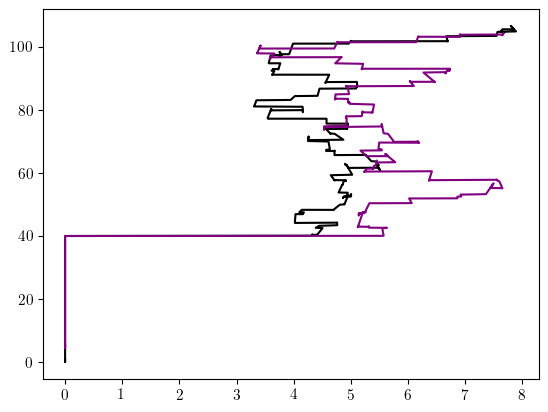

In [164]:
# l_lim = 0 ; u_lim = 5400
l_lim = 0 ; u_lim = 3240
plt.plot(q_lidar_wind[l_lim:u_lim], alt[l_lim:u_lim], color='black')
l_lim = 3240 ; u_lim = 5400
plt.plot(q_lidar_wind[l_lim:u_lim], alt[l_lim:u_lim], color='purple')
plt.show()

In [ ]:
# np.savetxt("q_lidar_wind_1.csv", q_lidar_wind, delimiter=",")

# Continue from here !

In [66]:
q_lidar_0 = np.genfromtxt('q_lidar_wind.csv', delimiter=',')
q_lidar_1 = np.genfromtxt('q_lidar_wind_1.csv', delimiter=',')
q_lidars = [q_lidar_0, q_lidar_1]

In [67]:
alt_40=np.where(alt>40.)
alt_40

(array([1707, 1708, 1709, ..., 4275, 4276, 4277]),)

## Change the flight_nr inorder to analyse flight 0 or 1

In [75]:
flight_nr = 0

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Serif"
plt.rcParams["font.size"] = 11  
fig=plt.figure(figsize=(4,5))

sf = 10 ; freq = 0.02 ; freq_l = 0.05 ; freq_q_alt = 0.05

phi, theta, psi, alt = filter_signal(quad_dfs[flight_nr], freq=0.2)

T_body = np.array([0., 0., 1.])
m=1.0 ; g=9.81 ; i=0

T_enu = np.zeros((len(phi),3))
alpha = np.zeros(len(phi))
for _phi , _the, _psi in zip(phi, theta, psi):
    r = R.from_euler('xyz', [_phi,_the,_psi], degrees=True)
    R_IB = r.as_matrix()
    T_norm = R_IB @ T_body
    T_enu[i,:] = m*g*(T_norm/T_norm[2])
    alpha[i] = np.arccos(T_norm[2])
    i+=1

alt_40=np.where(alt>40.)
ql_alt_s = smooth_signal(alt[alt_40], sf=sf, freq=freq_q_alt)
lidar_s =  smooth_signal(q_lidars[flight_nr][alt_40], sf=10,  freq=freq_l)

alpha_s = smooth_signal(alpha, sf=sf, freq=freq) * 45
q_alt_s = smooth_signal(alt, sf=sf, freq=freq_q_alt)

# high=np.where(alt==max(alt))[0][0]
high=np.where(ql_alt_s==max(ql_alt_s))[0][0]

# plt.plot(lidar_s[:high],ql_alt_s[:high], label='During Ascend')
# plt.plot(lidar_s[high:],ql_alt_s[high:], label='During Descend')
# plt.grid();plt.xlabel('Wind Speed [m/s]');plt.ylabel('Height AGL [m]');plt.legend()
# plt.savefig('plots/vertical_profile1.pdf', dpi=30, bbox_inches='tight')
# plt.show()

Sampling Frequency : 10.001852194850935


<Figure size 400x500 with 0 Axes>

(-4.0, 110.0)

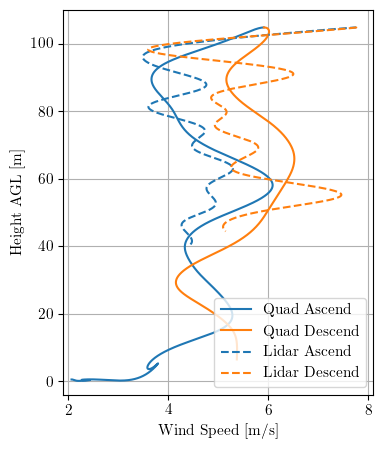

In [76]:
fig=plt.figure(figsize=(4,5))

high=np.where(q_alt_s==max(q_alt_s))[0][0]
plt.plot(alpha_s[:high], q_alt_s[:high], label='Quad Ascend')
plt.plot(alpha_s[high:], q_alt_s[high:], label='Quad Descend')

high=np.where(ql_alt_s==max(ql_alt_s))[0][0]
plt.plot(lidar_s[:high],ql_alt_s[:high], '--', color='C0', label='Lidar Ascend')
plt.plot(lidar_s[high:],ql_alt_s[high:], '--', color='C1', label='Lidar Descend')
plt.grid();plt.xlabel('Wind Speed [m/s]');plt.ylabel('Height AGL [m]');plt.legend()
plt.xlim([1.9, 8.1])
plt.ylim([-4,110])
# plt.savefig(f'plots/quad_lidar_vertical_wind_profile_{flight_nr}.pdf', dpi=30, bbox_inches='tight')